## **1- importing some libraries**

In [1]:
#Imports set up
import torch
import zipfile
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time, os

In [7]:
# Clone the GitHub repo
!git clone https://github.com/salma-033/dog-vs-cat.git

# Set path to dataset inside the cloned repo
data_dir = "/content/dog-vs-cat"

# PyTorch transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# Load the image folders
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

# Create dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

# Get class names and device
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Pretrained model loading
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False  # freeze layers

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # binary classification
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 247MB/s]


In [9]:
# Loss and Optimizer definition
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)



In [10]:
# Loop training
def train_model(model, criterion, optimizer, num_epochs=5):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, train_losses, val_losses, train_acc, val_acc

model, train_losses, val_losses, train_acc, val_acc = train_model(model, criterion, optimizer, num_epochs=5)





Epoch 1/5
----------
train Loss: 0.4384 Acc: 0.8109
val Loss: 0.3185 Acc: 0.9714
Epoch 2/5
----------
train Loss: 0.3196 Acc: 0.9236
val Loss: 0.2352 Acc: 0.9143
Epoch 3/5
----------
train Loss: 0.2181 Acc: 0.9418
val Loss: 0.1689 Acc: 0.9714
Epoch 4/5
----------
train Loss: 0.1595 Acc: 0.9564
val Loss: 0.1508 Acc: 0.9857
Epoch 5/5
----------
train Loss: 0.1300 Acc: 0.9745
val Loss: 0.1317 Acc: 0.9714


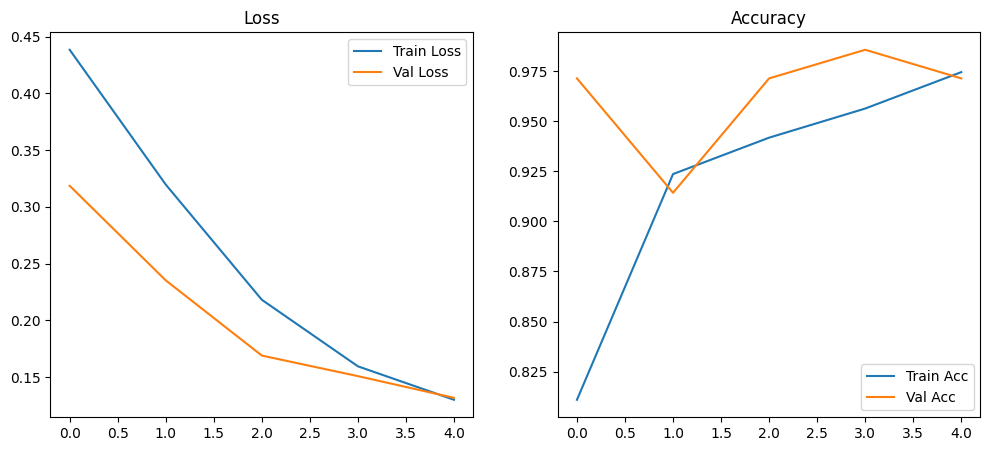

In [11]:
# Results plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [12]:
from PIL import Image
import torchvision.transforms as transforms

torch.save(model.state_dict(), 'binary_classifier.pth')

def predict_image(image_path):
    model.eval()
    img = Image.open(image_path)
    transform = data_transforms['val']
    img_t = transform(img).unsqueeze(0).to(device)

    outputs = model(img_t)
    _, pred = torch.max(outputs, 1)
    print(f"Predicted: {class_names[pred.item()]}")

In [13]:
#QA
predict_image("/content/csm_schwarzer_Hund_auf_Wiese_c_xkunclova-Shutterstock_01_5566a80d25.webp")
predict_image("/content/NationalGeographic_2572187_16x9.avif")

FileNotFoundError: [Errno 2] No such file or directory: '/content/csm_schwarzer_Hund_auf_Wiese_c_xkunclova-Shutterstock_01_5566a80d25.webp'